<h2> Loan Club - Data Science Project </h2>

Lending Club to firma pożyczkowa typu peer-to-peer, która łączy pożyczkobiorców z inwestorami za pośrednictwem platformy internetowej. Obsługuje osoby, które potrzebują pożyczek osobistych w wysokości od 1000 do 40 000 USD. Pożyczkobiorcy otrzymują pełną kwotę udzielonej pożyczki pomniejszoną o opłatę początkową, która jest uiszczana firmie. Inwestorzy kupują weksle zabezpieczone osobistymi pożyczkami i płacą Lending Club opłatę za usługę. Firma Lending Club udostępnia dane o wszystkich pożyczkach udzielonych za pośrednictwem swojej platformy w określonych okresach. Na potrzeby tego projektu zostały użyte dane dotyczące pożyczek udzielonych za pośrednictwem Lending Club na przestrzeni lat 2007-2011. Każda pożyczka jest opatrzona informacją o tym, czy ostatecznie została spłacona (Fully Paid lub Charged off w kolumnie loan_status). Projekt opiera się na budowaniu modelu klasyfikacyjnego, który na podstawie tych danych będzie przewidywał z określoną dokładnością, czy potencjalny pożyczkobiorca spłaci swój dług z tytułu zaciągniętej pożyczki.

1. Obróbka danych

In [409]:
# Rozpoczynam od importu niezbędnych bibliotek
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f_oneway, pearsonr, ttest_ind, chi2_contingency

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    silhouette_score
)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

import lightgbm as lgb
import xgboost as xgb

import warnings

warnings.filterwarnings('ignore')

# Importuję plik zawierający dane Lending Club
df = pd.read_csv('loan_data.csv', low_memory=False)

# Wyświetlam listę wszystkich kolumn
print(list(df.columns))

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

In [410]:
# Usuwam kolumny zawierające dane z przyszłości, niedostępne w momencie udzielania pożyczki.
future_data_columns = [
    # 1. Płatności
    'total_pymnt',  # Płatności otrzymane do tej pory
    'total_pymnt_inv',  # Płatności od inwestorów
    'total_rec_prncp',  # Kapitał otrzymany do tej pory
    'total_rec_int',  # Odsetki otrzymane do tej pory
    'total_rec_late_fee',  # Opłaty za opóźnienie
    'recoveries',  # Odzyskane kwoty po charge-off
    'collection_recovery_fee',  # Opłaty windykacyjne
    'last_pymnt_d',  # Data ostatniej płatności
    'last_pymnt_amnt',  # Kwota ostatniej płatności
    'next_pymnt_d',  # Następna zaplanowana płatność

    # 2. Ugody
    'debt_settlement_flag',  # Flaga ugody długów
    'debt_settlement_flag_date',  # Data flagi ugody
    'settlement_status',  # Status ugody
    'settlement_date',  # Data ugody
    'settlement_amount',  # Kwota ugody
    'settlement_percentage',  # Procent ugody
    'settlement_term',  # Okres ugody

    # 3. Dane aktualizowane już po udzieleniu pożyczki
    'last_credit_pull_d',  # Ostatnie sprawdzenie kredytu
    'last_fico_range_high',  # Zaktualizowany FICO (wysoki)
    'last_fico_range_low',  # Zaktualizowany FICO (niski)
]
df = df.drop(columns=future_data_columns)

# Usuwam kolumny ze zbędnymi informacjami.
df = df.drop(columns=['id', 'url'])

# Usuwam kolumny z tylko jedną unikalną wartością.
single_value_columns = df.columns[df.nunique() == 1].tolist()
df = df.drop(columns=single_value_columns)

# Usuwam kolumny, które zawierają wyłącznie wartości NaN.
columns_only_nan = df.columns[df.isnull().all()].tolist()
df = df.drop(columns=columns_only_nan)

# Usuwam wiersze, które zawierają wyłącznie wartości NaN.
df = df.dropna(how='all')

# Usuwam kolumny z liczbą pustych pól większą niż 20%.
df = df.dropna(axis=1, thresh=0.8*len(df))

# Usuwam wiersze, które zawierają więcej niż 10 pustych pól.
df = df.dropna(axis=0, thresh=10)

In [411]:
# ZMIENNA DOCELOWA
# Sprawdzam unikalne wartości w kolumnie ze statusem pożyczki
print(df['loan_status'].unique())

['Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


In [412]:
# Informacja o polityce kredytowej nie jest istotna, dlatego redukuję unikalne wartości kolumny loan_status z 4 do 2
mapping = {
    'Does not meet the credit policy. Status:Charged Off': 'Charged Off',
    'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid'
}
df['loan_status'] = df['loan_status'].replace(mapping)

# Przypisuję pożyczkom niespłaconym wartość 0, a spłaconym wartość 1
df['loan_status'] = df['loan_status'].map({
    'Charged Off' : 0,
    'Fully Paid' : 1
}).astype("int32")

In [413]:
# Przekształcam wartości w kolumnach
# Usuwam tekst "months" z kolumny "term" i konwertuję typ na float
df['term'] = df['term'].str.extract(r'(\d+)').astype(float)

# Usuwam znak '%' z wartości w kolumnach 'int_rate' i 'revol_util' i konwertuję typy na float
df['int_rate'] = pd.to_numeric(df['int_rate'].str.replace('%', ''), errors='coerce').astype(float)
df['revol_util'] = pd.to_numeric(df['revol_util'].str.replace('%', ''), errors='coerce').astype(float)

In [414]:
# Analiza brakujących wartości
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_percent = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'missing': missing_counts,
    'percent': missing_percent.round(2)
}).sort_values(by='percent', ascending=False)

print("Brakujące wartości w kolumnach:")
print(missing_df)

Brakujące wartości w kolumnach:
                      missing  percent
emp_title                2626     6.17
pub_rec_bankruptcies     1365     3.21
emp_length               1112     2.61
tax_liens                 105     0.25
revol_util                 90     0.21
delinq_2yrs                29     0.07
earliest_cr_line           29     0.07
inq_last_6mths             29     0.07
open_acc                   29     0.07
pub_rec                    29     0.07
total_acc                  29     0.07
acc_now_delinq             29     0.07
delinq_amnt                29     0.07
title                      13     0.03
annual_inc                  4     0.01


In [415]:
# Analizuję kolumnę "title"
print(f"Brakujące wartości: {df['title'].isnull().sum()} ({df['title'].isnull().sum()/len(df)*100:.1f}%)")
print(f"Unikalne wartości: {df['title'].nunique()}")

print("\nNajpopularniejsze tytuły pożyczek:")
print(df['title'].value_counts().head(10))

df['title_length'] = df['title'].str.len()
correlation = df['title_length'].corr(df['loan_status'])
print(f"\nKorelacja długość tytułu-spłacalność: {correlation:.4f}")

Brakujące wartości: 13 (0.0%)
Unikalne wartości: 21264

Najpopularniejsze tytuły pożyczek:
title
Debt Consolidation           2259
Debt Consolidation Loan      1760
Personal Loan                 708
Consolidation                 547
debt consolidation            532
Home Improvement              373
Credit Card Consolidation     370
Debt consolidation            347
Small Business Loan           333
Personal                      330
Name: count, dtype: int64

Korelacja długość tytułu-spłacalność: 0.0142


Kolumna "title" posiada ponad 21 tysięcy unikalnych wartości, dlatego uważam, że nie ma ona wpływu predykcyjnego. Również długość opisu jest w niewielkim stopniu skorelowana ze spłacalnością pożyczki, dlatego obie kolumny uznaję za nieprzydatne w dalszej analizie.

In [416]:
# Analizuję kolumnę emp_title
print(f"Brakujące wartości: {df['emp_title'].isnull().sum()} ({df['emp_title'].isnull().sum()/len(df)*100:.1f}%)")
print(f"Unikalne wartości: {df['emp_title'].nunique()}")

print("\nNajpopularniejsze tytuły pracy:")
print(df['emp_title'].value_counts().head(10))

has_emp_title = df['emp_title'].notna()
comparison = df.groupby(has_emp_title)['loan_status'].mean() * 100

print(f"\nSpłacalność:")
print(f"Brak tytułu: {comparison[False]:.1f}% spłaconych")
print(f"Ma tytuł: {comparison[True]:.1f}% spłaconych")

table = pd.crosstab(has_emp_title, df['loan_status'])
chi2, p_value, _, _ = chi2_contingency(table)
print(f"\nChi2: {chi2:.2f}, p-value: {p_value:.6f}")

Brakujące wartości: 2626 (6.2%)
Unikalne wartości: 30658

Najpopularniejsze tytuły pracy:
emp_title
US Army              139
Bank of America      115
IBM                   72
Kaiser Permanente     61
AT&T                  61
UPS                   58
Wells Fargo           57
USAF                  56
US Air Force          55
Self Employed         49
Name: count, dtype: int64

Spłacalność:
Brak tytułu: 79.6% spłaconych
Ma tytuł: 85.2% spłaconych

Chi2: 60.64, p-value: 0.000000


W kolumnie "emp_title" występuje bardzo duża różnorodność oraz znacząca różnica pomiędzy spłacalnością pożyczek wśród osób, które nie mają wprowadzonych wartości w kolumnie "emp_title" a tymi, którzy mają te dane. Postanawiam wprowadzić dodatkową kolumnę, która określać będzie, czy potencjalny pożyczkobiorca posiada dane w kolumnie "emp_title", a samą kolumnę "emp_title" usuwam.

In [417]:
df['provided_emp_title'] = df['emp_title'].notna().astype(float)
df = df.drop('emp_title', axis=1)

In [418]:
# Wypełniam zerami poniższe kolumny.
for col in ['pub_rec_bankruptcies', 'tax_liens', 'delinq_amnt', 'acc_now_delinq', 'pub_rec']:
    df[col] = df[col].fillna(0)

# Wypełniam medianą pola numeryczne.
for col in ['annual_inc', 'revol_util', 'open_acc', 'total_acc',
            'delinq_2yrs', 'inq_last_6mths']:
    df[col] = df[col].fillna(df[col].median())

# Konwertuję earliest_cr_line na liczbę miesięcy, które upłynęły od issue_d, czyli dnia przyznania pożyczki.
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
df['earliest_cr_line'] = (df['issue_d'] - df['earliest_cr_line']).dt.days // 30

# Brakujące wartości wypełniamy zerem
df['earliest_cr_line'] = df['earliest_cr_line'].fillna(0)

# Zastępuję puste wartości z kolumny "emp_length" zerami, a później przekształcam opisy tekstowe na wartości liczbowe.
df['emp_length'] = df['emp_length'].replace({
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}).fillna(0).astype(float)

# Fico_range_low i Fico_range_high są bardzo zbliżone do siebie i niosą podobną wartość predykcyjną, dlatego tworzę z nich średnią.
df["fico_range"] = (df.fico_range_low + df.fico_range_high)/2

# Usuwam kolumny fico_range_low i fico_range_high
df = df.drop(["fico_range_low", "fico_range_high"], axis=1)

2. Eksploracyjna analiza danych

Aktualny rozmiar zbioru: 42535 wierszy, 34 kolumn
Rozkład spłacalności:
Spłacone (1): 36104 (84.9%)
Niespłacone (0): 6431 (15.1%)


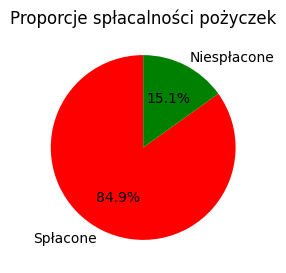

In [419]:
# Ustawienia dla wykresów
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(f"Aktualny rozmiar zbioru: {df.shape[0]} wierszy, {df.shape[1]} kolumn")

# Podstawowe statystyki dla zmiennej docelowej
loan_status_counts = df['loan_status'].value_counts()
print("Rozkład spłacalności:")
print(f"Spłacone (1): {loan_status_counts[1]} ({loan_status_counts[1]/len(df)*100:.1f}%)")
print(f"Niespłacone (0): {loan_status_counts[0]} ({loan_status_counts[0]/len(df)*100:.1f}%)")

# Wizualizacja zmiennej docelowej
plt.figure(figsize=(4, 3))
plt.pie(df['loan_status'].value_counts(), labels=['Spłacone', 'Niespłacone'],
        colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
plt.title('Proporcje spłacalności pożyczek')
plt.show()


ROZKŁADY ZMIENNYCH


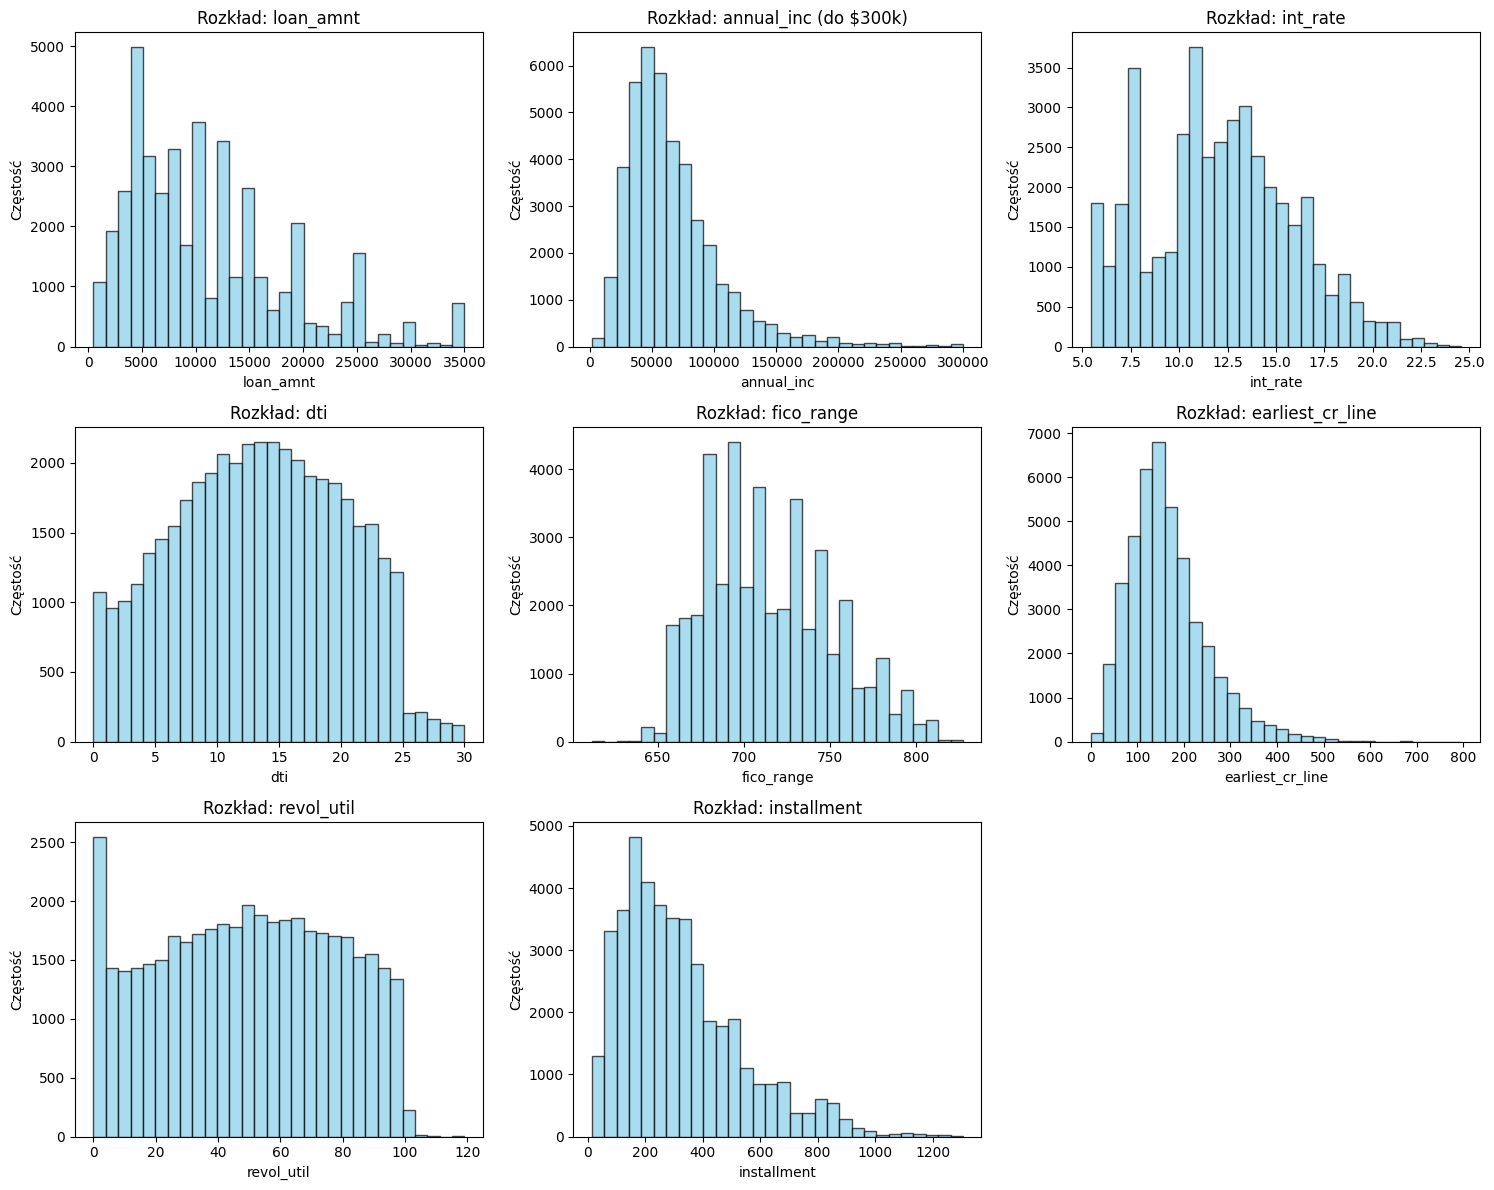

In [420]:
# Wybieram kluczowe zmienne numeryczne do analizy
key_numeric_cols = ['loan_amnt', 'annual_inc', 'int_rate', 'dti', 'fico_range',
                   'earliest_cr_line', 'revol_util', 'installment']

# Tworzę wykresy rozkładów kluczowych zmiennych
print("\nROZKŁADY ZMIENNYCH")
plt.figure(figsize=(15, 12))

# Filtracja annual_inc do 300,000 dla lepszej wizualizacji
df_filtered = df.copy()
df_filtered.loc[df_filtered['annual_inc'] > 300000, 'annual_inc'] = np.nan

for i, col in enumerate(key_numeric_cols, 1):
    plt.subplot(3, 3, i)
    if col == 'annual_inc':
        data_to_plot = df_filtered[col].dropna()
        plt.hist(data_to_plot, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Rozkład: {col} (do $300k)')
    else:
        plt.hist(df[col].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Rozkład: {col}')
    plt.xlabel(col)
    plt.ylabel('Częstość')

plt.tight_layout()
plt.show()

Na większości wykresów wartości koncentrują się w niższych przedziałach. Jest to np. widoczne dla kwot kredytów i dochodów rocznych, gdzie dominują mniejsze kwoty i przeciętne zarobki, podczas gdy klienci o bardzo wysokich parametrach finansowych stanowią mniejszość. Wskaźnik DTI ma rozkład niemal symetryczny, wskazując na zrównoważone rozłożenie poziomów zadłużenia w populacji. Ocena FICO koncentruje się w wyższych przedziałach z przewagą klientów o dobrej zdolności kredytowej, co wynika prawdopodobnie z tego, że Loan Club nie udzielał pożyczek osobom z niską oceną FICO.

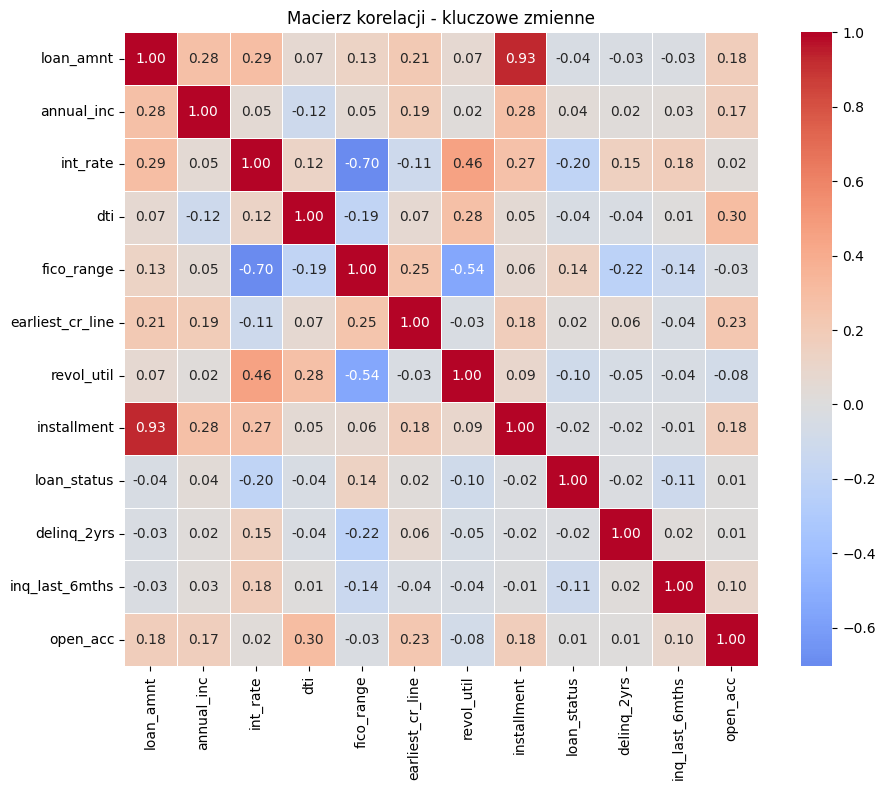

In [421]:
# Macierz korelacji dla zmiennych numerycznych
extended_cols = key_numeric_cols + ['loan_status', 'delinq_2yrs', 'inq_last_6mths', 'open_acc']
correlation_matrix = df[extended_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Macierz korelacji - kluczowe zmienne')
plt.tight_layout()
plt.show()

In [422]:
# Top korelacje ze zmienną docelową
print("Najsilniejsze korelacje ze spłacalnością (loan_status):")
target_correlations = correlation_matrix['loan_status'].drop('loan_status').sort_values(key=abs, ascending=False)
for var, corr in target_correlations.head(8).items():  # zwiększone z 5 do 8
    print(f"{var}: {corr:.4f}")

Najsilniejsze korelacje ze spłacalnością (loan_status):
int_rate: -0.2006
fico_range: 0.1419
inq_last_6mths: -0.1109
revol_util: -0.0953
loan_amnt: -0.0426
dti: -0.0422
annual_inc: 0.0380
earliest_cr_line: 0.0219


Czym wyższy wskaźnik FICO, dochody i długość historii kredytowej, tym wyższe prawdopodobieństwo spłaty pożyczki. Odwrotną korelację ma natomiast liczba zapytań kredytowych w ostatnich 6 miesiącach oraz wyższe wykorzystanie kredytu odnawialnego.

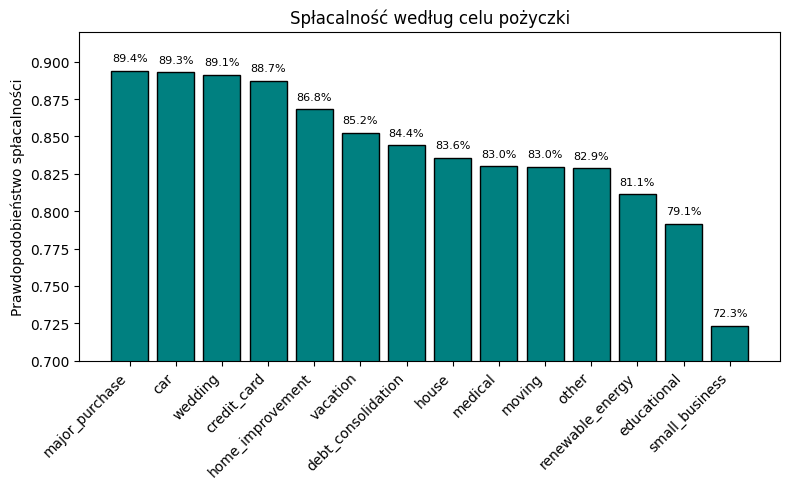

Chi-kwadrat dla celu: 426.0405 (p=7.00e-83)

Ranking celów według spłacalności:
 1. major_purchase: 89.4% (n=2311)
 2. car: 89.3% (n=1615)
 3. wedding: 89.1% (n=1004)
 4. credit_card: 88.7% (n=5477)
 5. home_improvement: 86.8% (n=3199)
 6. vacation: 85.2% (n=400)
 7. debt_consolidation: 84.4% (n=19776)
 8. house: 83.6% (n=426)
 9. medical: 83.0% (n=753)
10. moving: 83.0% (n=629)
11. other: 82.9% (n=4425)
12. renewable_energy: 81.1% (n=106)
13. educational: 79.1% (n=422)
14. small_business: 72.3% (n=1992)
OGÓLNA SPŁACALNOŚĆ: 84.9%
ROZKŁAD: 36104 spłaconych, 6431 niespłaconych


In [423]:
# Analizuję cel pożyczki
if 'purpose' in df.columns:
    purpose_summary = df.groupby('purpose').agg(
        repayment_rate=('loan_status', lambda x: (x == 1).mean()),
        count=('loan_status', 'count')
    ).reset_index().sort_values('repayment_rate', ascending=False)

    plt.figure(figsize=(8, 5))
    bars = plt.bar(range(len(purpose_summary)), purpose_summary['repayment_rate'],
                   color='teal', edgecolor='black')
    plt.xticks(range(len(purpose_summary)), purpose_summary['purpose'], rotation=45, ha='right')
    plt.ylabel('Prawdopodobieństwo spłacalności')
    plt.title('Spłacalność według celu pożyczki')
    plt.ylim(0.7, 0.92)
    for i, (bar, row) in enumerate(zip(bars, purpose_summary.itertuples())):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{row.repayment_rate:.1%}', ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

    # Test chi-kwadrat dla celu pożyczki
    contingency_purpose = pd.crosstab(df['purpose'], df['loan_status'])
    chi2_purpose, p_purpose, dof_purpose, ex_purpose = chi2_contingency(contingency_purpose)

    print(f"Chi-kwadrat dla celu: {chi2_purpose:.4f} (p={p_purpose:.2e})")
    print("\nRanking celów według spłacalności:")
    for i, (_, row) in enumerate(purpose_summary.iterrows(), 1):
        print(f"{i:2d}. {row['purpose']}: {row['repayment_rate']:.1%} (n={row['count']})")

print(f"OGÓLNA SPŁACALNOŚĆ: {df['loan_status'].mean():.1%}")
print(f"ROZKŁAD: {loan_status_counts[1]} spłaconych, {loan_status_counts[0]} niespłaconych")

Pożyczki konsumpcyjne mają najwyższą spłacalność, a najniższą pożyczki biznesowe. Największą grupą celu jest konsolidacja długów.
Test chi-kwadrat (426.04, p=7.00e-83) wskazuje na bardzo silną zależność statystyczną między celem kredytu a spłacalnością. Wartość p praktycznie równa zeru oznacza, że możemy z całą pewnością odrzucić hipotezę zerową o braku związku.

1. W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?

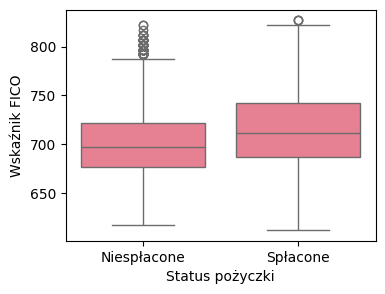

In [424]:
# Rozpoczynam od porównania średniego wyniku FICO dla pożyczek niespłaconych i spłaconych
plt.figure(figsize=(4, 3), dpi=100)
sns.boxplot(data=df, x='loan_status', y='fico_range')
plt.xlabel('Status pożyczki')
plt.ylabel('Wskaźnik FICO')
plt.xticks(ticks=[0, 1], labels=['Niespłacone', 'Spłacone'])
plt.show()

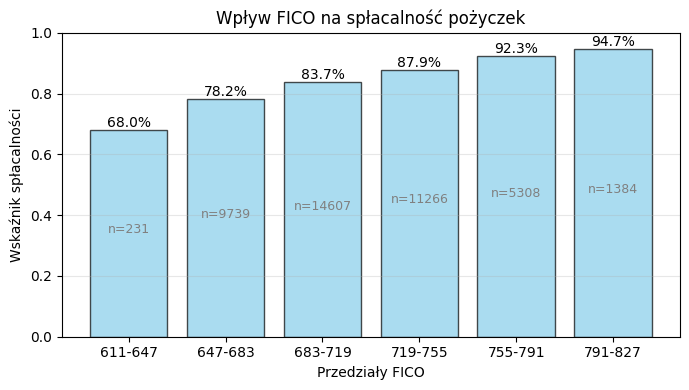

In [425]:
# Następnie generuję wykres przedstawiający spłacalność pożyczek w zależności od wskaźnika FICO
plt.figure(figsize=(7, 4))
df['fico_group'] = pd.cut(df['fico_range'], bins=6)
summary = df.groupby('fico_group', observed=False)['loan_status'].agg(['mean', 'count']).reset_index()
labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in summary['fico_group']]
plt.bar(labels, summary['mean'], color='skyblue', edgecolor='black', alpha=0.7)

for i, (rate, count) in enumerate(zip(summary['mean'], summary['count'])):
    plt.text(i, rate + 0.01, f"{rate:.1%}", ha='center')
    plt.text(i, rate / 2, f"n={count}", ha='center', fontsize=9, color='gray')

plt.xlabel('Przedziały FICO')
plt.ylabel('Wskaźnik spłacalności')
plt.title('Wpływ FICO na spłacalność pożyczek')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [426]:
# Wykonuję również test statystyczny
paid_fico = df[df['loan_status'] == 1]['fico_range']
unpaid_fico = df[df['loan_status'] == 0]['fico_range']
t_stat, p_value = ttest_ind(paid_fico, unpaid_fico)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.2e}")

T-statistic: 29.5676
P-value: 3.31e-190


Na podstawie wizualizacji oraz przeprowadzonego testu statystycznego można stwierdzić, że wraz ze wzrostem wskaźnika FICO rośnie prawdopodobieństwo spłaty pożyczki. Warto jednak zauważyć, że Lending Club najprawdopodobniej odrzucał wnioski z bardzo niskim wynikiem FICO, które nie znalazły się w analizowanym zbiorze danych. Gdyby te odrzucone wnioski były uwzględnione, zależność między FICO a spłacalnością pożyczek byłaby jeszcze bardziej wyraźna.

2. W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO?

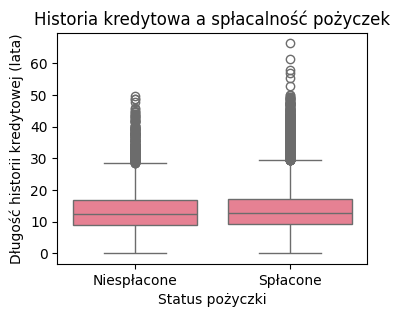

In [427]:
# Konwertuj miesiące na lata
df['earliest_cr_line_years'] = df['earliest_cr_line'] / 12

# Tworzę wykres pudełkowy wieku historii kredytowej względem statusu pożyczki
plt.figure(figsize=(4, 3), dpi=100)
sns.boxplot(data=df, x='loan_status', y='earliest_cr_line_years')
plt.xlabel('Status pożyczki')
plt.ylabel('Długość historii kredytowej (lata)')
plt.xticks(ticks=[0, 1], labels=['Niespłacone', 'Spłacone'])
plt.title('Historia kredytowa a spłacalność pożyczek')
plt.show()

Min lat: 0.0
Max lat: 66.3
Średnia: 13.8


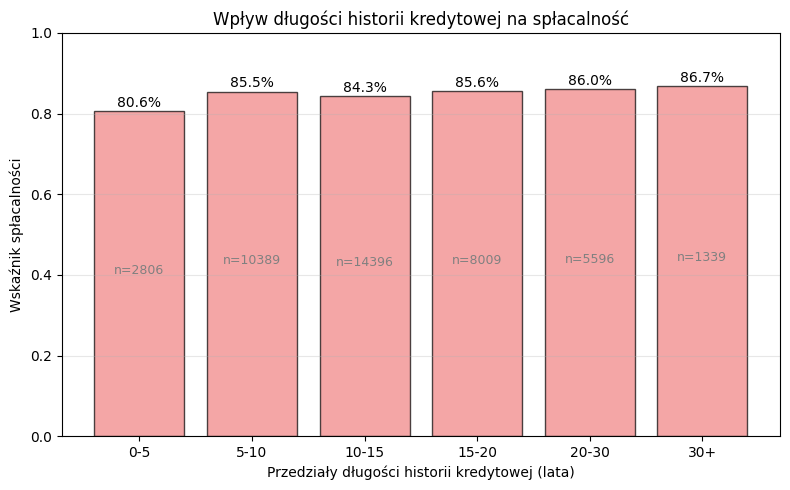

In [428]:
# Sprawdzam zakres danych
print(f"Min lat: {df['earliest_cr_line_years'].min():.1f}")
print(f"Max lat: {df['earliest_cr_line_years'].max():.1f}")
print(f"Średnia: {df['earliest_cr_line_years'].mean():.1f}")

# Grupuję dane w przedziały
bins = [0, 5, 10, 15, 20, 30, 100]
labels = ['0-5', '5-10', '10-15', '15-20', '20-30', '30+']

df['credit_hist_group'] = pd.cut(df['earliest_cr_line_years'], bins=bins, labels=labels, include_lowest=True)

summary_age = df.groupby('credit_hist_group', observed=False)['loan_status'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(8, 5))
plt.bar(range(len(summary_age)), summary_age['mean'], color='lightcoral', edgecolor='black', alpha=0.7)
plt.xticks(range(len(summary_age)), summary_age['credit_hist_group'])

for i, (rate, count) in enumerate(zip(summary_age['mean'], summary_age['count'])):
    plt.text(i, rate + 0.01, f"{rate:.1%}", ha='center')
    plt.text(i, rate / 2, f"n={count}", ha='center', fontsize=9, color='gray')

plt.xlabel('Przedziały długości historii kredytowej (lata)')
plt.ylabel('Wskaźnik spłacalności')
plt.title('Wpływ długości historii kredytowej na spłacalność')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [429]:
# Wyświetlam szczegóły przedziałów
print("\nRozkład w przedziałach:")
for _, row in summary_age.iterrows():
    print(f"{row['credit_hist_group']}: {row['mean']:.1%} spłacalności (n={row['count']})")

# Test t dla różnic w historii kredytowej
paid_age = df[df['loan_status'] == 1]['earliest_cr_line_years']
unpaid_age = df[df['loan_status'] == 0]['earliest_cr_line_years']

t_stat_age, p_value_age = ttest_ind(paid_age, unpaid_age, equal_var=False)
print(f"\nT-statistic dla historii kredytowej: {t_stat_age:.4f}")
print(f"P-value dla historii kredytowej: {p_value_age:.2e}")

corr, p_corr = pearsonr(df['earliest_cr_line_years'], df['fico_range'])
print(f"Korelacja długości historii kredytowej i FICO: {corr:.3f} (p={p_corr:.2e})")


Rozkład w przedziałach:
0-5: 80.6% spłacalności (n=2806)
5-10: 85.5% spłacalności (n=10389)
10-15: 84.3% spłacalności (n=14396)
15-20: 85.6% spłacalności (n=8009)
20-30: 86.0% spłacalności (n=5596)
30+: 86.7% spłacalności (n=1339)

T-statistic dla historii kredytowej: 4.5452
P-value dla historii kredytowej: 5.56e-06
Korelacja długości historii kredytowej i FICO: 0.247 (p=0.00e+00)


Na podstawie wizualizacji oraz testów statystycznych widać, że dłuższa historia kredytowa wiąże się z mniejszym ryzykiem niewykonania zobowiązania, aczkolwiek różnice w spłacalności pomiędzy poszczególnymi grupami są niewielkie. Obarczone największym ryzykiem są pożyczki u osób z najkrótszą historią kredytową.
Korelacja między długością historii kredytowej a wynikiem FICO jest umiarkowana, co sugeruje, że oba czynniki są powiązane i łącznie wpływają na ocenę ryzyka pożyczkobiorcy.

3. W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?

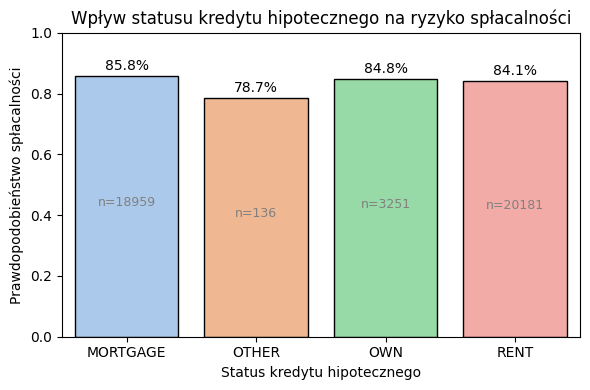

Chi-kwadrat: 25.0035
P-value: 1.54e-05


In [430]:
# Kolumna home_ownership zawiera tylko 8 wpisów z wartością 'NONE', dlatego postanawiam usunąć te wiersze.
df = df[df['home_ownership'] != 'NONE'].copy()

# Grupowanie i obliczenie wskaźnika spłacalności (loan_status == 1) dla każdej kategorii
summary_home = df.groupby('home_ownership').agg(
    repayment_rate=('loan_status', lambda x: (x == 1).mean()),
    count=('loan_status', 'count')
).reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=summary_home, x='home_ownership', y='repayment_rate', palette='pastel', edgecolor='black')

plt.xlabel('Status kredytu hipotecznego')
plt.ylabel('Prawdopodobieństwo spłacalności')
plt.title('Wpływ statusu kredytu hipotecznego na ryzyko spłacalności')
plt.ylim(0, 1)

for i, row in summary_home.iterrows():
    plt.text(i, row['repayment_rate'] + 0.02, f"{row['repayment_rate']:.1%}", ha='center')
    plt.text(i, row['repayment_rate'] / 2, f"n={int(row['count'])}", ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# Test statystyczny chi-kwadrat, aby sprawdzić zależność między home_ownership a spłacalnością
contingency_table = pd.crosstab(df['home_ownership'], df['loan_status'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-kwadrat: {chi2:.4f}")
print(f"P-value: {p:.2e}")

Analiza pokazuje, że status kredytu hipotecznego ma wpływ na prawdopodobieństwo spłacalności pożyczek.
Najwyższe wskaźniki spłacalności obserwujemy u właścicieli nieruchomości (OWN) oraz osób z kredytem hipotecznym (MORTGAGE), natomiast najniższe u osób wynajmujących (RENT) oraz posiadających inne formy własności (OTHER).
Test chi-kwadrat potwierdza istotną statystycznie zależność między statusem kredytu hipotecznego a spłacalnością (p < 0.05).

4. W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?

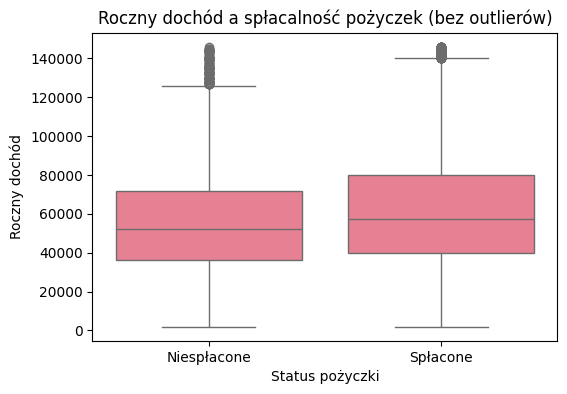

In [431]:
# Usuwam outliery z kolumny 'annual_inc' metodą IQR
Q1 = df['annual_inc'].quantile(0.25)
Q3 = df['annual_inc'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['annual_inc'] >= lower_bound) & (df['annual_inc'] <= upper_bound)].copy()

# Tworzę wykres pudełkowy rocznego dochodu względem statusu pożyczki
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_clean, x='loan_status', y='annual_inc')
plt.xlabel('Status pożyczki')
plt.ylabel('Roczny dochód')
plt.xticks(ticks=[0, 1], labels=['Niespłacone', 'Spłacone'])
plt.title('Roczny dochód a spłacalność pożyczek (bez outlierów)')
plt.show()

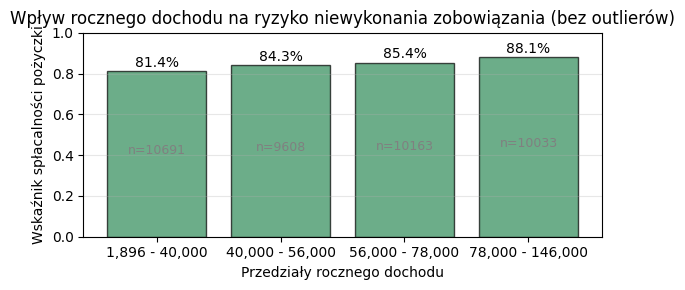

In [432]:
# Podział na kwartyle
df_clean['income_group'] = pd.qcut(df_clean['annual_inc'], q=4)

summary_income = df_clean.groupby('income_group', observed=False)['loan_status'].agg(['mean', 'count']).reset_index()

labels_income = [f"{interval.left:,.0f} - {interval.right:,.0f}" for interval in summary_income['income_group']]

plt.figure(figsize=(6, 3))
bars = plt.bar(labels_income, summary_income['mean'], color='seagreen', edgecolor='black', alpha=0.7)

for i, (rate, count) in enumerate(zip(summary_income['mean'], summary_income['count'])):
    plt.text(i, rate + 0.02, f"{rate:.1%}", ha='center', fontsize=10)
    plt.text(i, rate / 2, f"n={count}", ha='center', fontsize=9, color='gray')

plt.xlabel('Przedziały rocznego dochodu')
plt.ylabel('Wskaźnik spłacalności pożyczki')
plt.title('Wpływ rocznego dochodu na ryzyko niewykonania zobowiązania (bez outlierów)')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [433]:
# Test statystyczny różnicy średniego dochodu między spłaconymi a niespłaconymi (na danych bez outlierów)
paid_income = df_clean[df_clean['loan_status'] == 1]['annual_inc']
unpaid_income = df_clean[df_clean['loan_status'] == 0]['annual_inc']

t_stat_income, p_value_income = ttest_ind(paid_income, unpaid_income, equal_var=False)
print(f"T-statistic dla rocznego dochodu: {t_stat_income:.4f}")
print(f"P-value dla rocznego dochodu: {p_value_income:.2e}")

T-statistic dla rocznego dochodu: 14.1879
P-value dla rocznego dochodu: 3.42e-45


Na podstawie wizualizacji oraz testów statystycznych widać, że wyższy roczny dochód jest związany z większym prawdopodobieństwem spłaty pożyczki. Test t-Studenta potwierdza istotną statystycznie różnicę w dochodach między grupą spłacającą a niespłacającą pożyczkę.

5. W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?

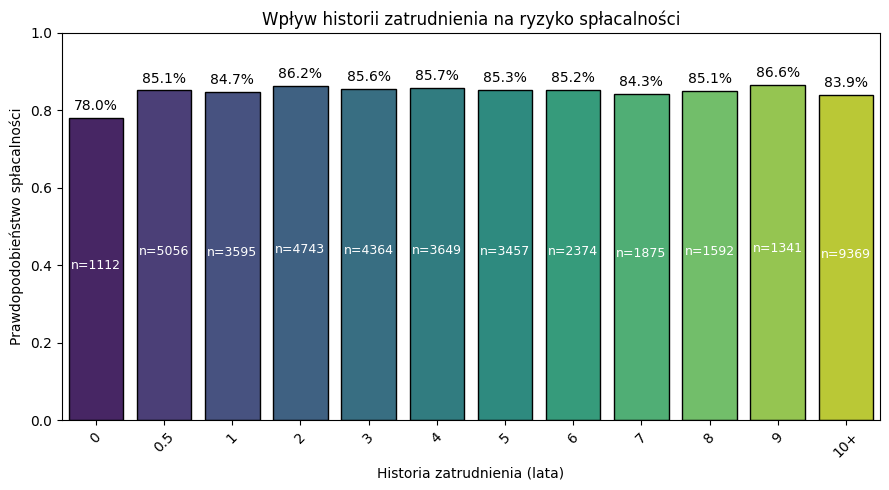

Korelacja Pearsona: -0.0052
P-value: 2.86e-01
ANOVA F-statystyka: 5.6800
ANOVA P-value: 3.25e-09


In [434]:
# Grupowanie i obliczenie wskaźnika spłacalności dla każdej kategorii długości zatrudnienia
summary_emp = df.groupby('emp_length').agg(
    repayment_rate=('loan_status', lambda x: (x == 1).mean()),  # odsetek spłaconych pożyczek
    count=('loan_status', 'count')
).reset_index()

# Sortowanie według długości zatrudnienia dla lepszej wizualizacji
summary_emp = summary_emp.sort_values('emp_length')

plt.figure(figsize=(9, 5))
sns.barplot(data=summary_emp, x='emp_length', y='repayment_rate', palette='viridis', edgecolor='black')

plt.xlabel('Historia zatrudnienia (lata)')
plt.ylabel('Prawdopodobieństwo spłacalności')
plt.title('Wpływ historii zatrudnienia na ryzyko spłacalności')
plt.ylim(0, 1)

for i, row in summary_emp.iterrows():
    plt.text(i, row['repayment_rate'] + 0.02, f"{row['repayment_rate']:.1%}", ha='center')
    plt.text(i, row['repayment_rate'] / 2, f"n={int(row['count'])}", ha='center', fontsize=9, color='white')

# Dostosowanie etykiety osi x dla lepszej czytelności
emp_labels = ['0', '0.5', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
plt.xticks(range(len(summary_emp)), emp_labels, rotation=45)

plt.tight_layout()
plt.show()

# Test korelacji Pearsona między długością zatrudnienia a spłacalnością
correlation, p_value = pearsonr(df['emp_length'], df['loan_status'])

print(f"Korelacja Pearsona: {correlation:.4f}")
print(f"P-value: {p_value:.2e}")

# Grupowanie spłacalności według długości zatrudnienia
groups = [df[df['emp_length'] == length]['loan_status'].values
          for length in sorted(df['emp_length'].unique())]

f_stat, p_anova = f_oneway(*groups)

print(f"ANOVA F-statystyka: {f_stat:.4f}")
print(f"ANOVA P-value: {p_anova:.2e}")

Największe ryzyko kredytowe występuje u osób z bardzo krótką historią kredytową lub jej brakiem. Pomiędzy pozostałymi latami nie występują znaczne różnice w spłacalności pożyczek. Chociaż ogólna korelacja liniowa jest niemal zerowa, ANOVA pokazuje, że konkretne kategorie historii zatrudnienia różnią się pod względem ryzyka kredytowego. To sugeruje, że związek może być nieliniowy lub że niektóre specyficzne kategorie zatrudnienia wykazują odmienne wzorce ryzyka, mimo że ogólny trend liniowy jest niewidoczny.
Historia zatrudnienia ma więc ograniczoną wartość predykcyjną dla ryzyka kredytowego w tym zbiorze danych.

6. Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?

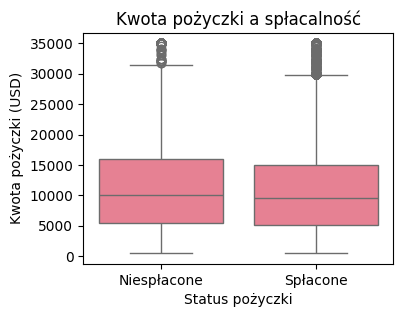

Różnica średniej kwoty pożyczki (spłacone - niespłacone): -879.44 USD


In [435]:
# Wykres pudełkowy kwoty pożyczki względem statusu
plt.figure(figsize=(4, 3), dpi=100)
sns.boxplot(data=df, x='loan_status', y='loan_amnt')
plt.xlabel('Status pożyczki')
plt.ylabel('Kwota pożyczki (USD)')
plt.xticks(ticks=[0, 1], labels=['Niespłacone', 'Spłacone'])
plt.title('Kwota pożyczki a spłacalność')
plt.show()

# Różnica średnich
means = df.groupby('loan_status')['loan_amnt'].mean()
print(f"Różnica średniej kwoty pożyczki (spłacone - niespłacone): {means[1] - means[0]:.2f} USD")

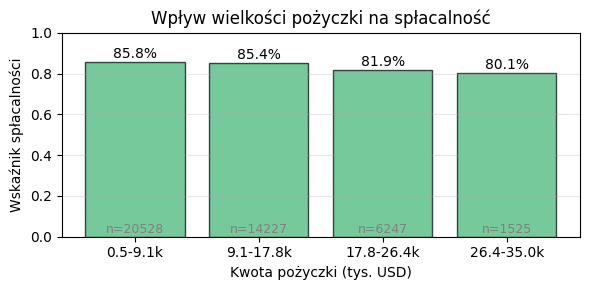

In [436]:
# Grupowanie na 4 przedziały
bins = np.linspace(df['loan_amnt'].min(), df['loan_amnt'].max(), 5)
df['loan_amnt_group'] = pd.cut(df['loan_amnt'], bins=bins, include_lowest=True)

summary = df.groupby('loan_amnt_group', observed=False)['loan_status'].agg(['mean', 'count']).reset_index()

# Skrócone etykiety w tysiącach USD
labels = [f"{interval.left/1000:.1f}-{interval.right/1000:.1f}k" for interval in summary['loan_amnt_group']]

# Wykres słupkowy
plt.figure(figsize=(6, 3))
bars = plt.bar(labels, summary['mean'], color='mediumseagreen', edgecolor='black', alpha=0.7)

for i, (rate, count) in enumerate(zip(summary['mean'], summary['count'])):
    plt.text(i, rate + 0.02, f"{rate:.1%}", ha='center')
    plt.text(i, 0.02, f"n={count}", ha='center', fontsize=9, color='gray')

plt.xlabel('Kwota pożyczki (tys. USD)')
plt.ylabel('Wskaźnik spłacalności')
plt.title('Wpływ wielkości pożyczki na spłacalność')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [437]:
# Test t-Studenta
paid_amount = df[df['loan_status'] == 1]['loan_amnt']
unpaid_amount = df[df['loan_status'] == 0]['loan_amnt']

t_stat, p_value = ttest_ind(paid_amount, unpaid_amount, equal_var=False)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value (t-test): {p_value:.2e}")

# Test chi-kwadrat — zależność między przedziałem kwoty a spłacalnością
contingency_table = pd.crosstab(df['loan_amnt_group'], df['loan_status'])
chi2, chi_p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2:.4f}")
print(f"P-value (chi²): {chi_p:.2e}")

T-statistic: -8.2516
P-value (t-test): 1.80e-16
Chi-squared: 84.6428
P-value (chi²): 3.10e-18


Średnia kwota pożyczki dla niespłaconych jest wyższa niż dla spłaconych. Wskaźnik spłacalności maleje wraz ze wzrostem kwoty pożyczki. Test t potwierdza istotność statystyczną różnicy średnich, tak jak i chi-kwadrat.

3. Feature Engineering

In [438]:
# Tworzę flagi oznaczające posiadanie wysokiego lub niskiego wskaźnika FICO.
with pd.option_context("mode.chained_assignment",None):
    df["fico_high"] = np.where(df["fico_range"]>750, 1, 0)
with pd.option_context("mode.chained_assignment",None):
    df["fico_low"] = np.where(df["fico_range"]<670, 1, 0)

In [439]:
# Tworzę zmienne wskaźnikowe (dummy variables) dla kolumn kategorycznych
dummies = pd.get_dummies(df[["home_ownership", "verification_status", "purpose"]], drop_first=False)
df = pd.concat([df, dummies], axis=1)

In [440]:
# Wskaźnik finansowy - stosunek otrzymanej kwoty do wnioskowanej
df['funding_ratio'] = df['funded_amnt'] / df['loan_amnt']

# Flaga pożyczki konsolidacyjnej
df['is_debt_consolidation'] = (df['purpose'] == 'debt_consolidation').astype(int)

# Stosunek pożyczki do dochodu
df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']

# Logarytm dochodu
df['log_annual_income'] = np.log(df['annual_inc'] + 1)

# Stosunek salda kredytu odnawialnego do dochodu rocznego
df['revol_bal_to_income'] = df['revol_bal'] / (df['annual_inc'] + 1e-9)

# Stosunek miesięcznej raty do miesięcznego dochodu
df['installment_to_monthly_income'] = df['installment'] / (df['annual_inc'] / 12)

# Flaga wysokiego DTI (powyżej 20%)
df['high_dti_flag'] = (df['dti'] > 20).astype(int)

# Flaga wysokiego wykorzystania kredytu odnawialnego (powyżej 70%)
df['high_revol_util_flag'] = (df['revol_util'] > 70).astype(int)

# Stosunek otwartych do wszystkich kont
df['open_to_total_acc_ratio'] = df['open_acc'] / (df['total_acc'] + 1e-9)

# Flaga niedawnych zapytań kredytowych (więcej niż 2 w ostatnich 6 miesiącach)
df['recent_inquiries_flag'] = (df['inq_last_6mths'] > 2).astype(int)

# Flaga problemów z płatnościami (zaległości w ostatnich 2 latach)
df['payment_issues_flag'] = (df['delinq_2yrs'] > 0).astype(int)

# Flaga problemów publicznych (bankructwa, zastawy)
df['public_records_flag'] = ((df['pub_rec_bankruptcies'] > 0) | (df['tax_liens'] > 0)).astype(int)

# Logarytm salda kredytu odnawialnego
df['log_revol_bal'] = np.log(df['revol_bal'] + 1)

# Stosunek kwoty kredytu do raty (ile rat potrzeba na spłatę)
df['loan_to_installment_ratio'] = df['loan_amnt'] / (df['installment'] + 1e-9)

# Flaga weryfikacji dochodów (zweryfikowane vs niezweryfikowane)
df['income_verified_flag'] = (df['verification_status_Verified'] == 1).astype(int)

# Flaga własności nieruchomości (hipoteka lub własna vs wynajmowana)
df['owns_property_flag'] = ((df['home_ownership_MORTGAGE'] == 1) | (df['home_ownership_OWN'] == 1)).astype(int)

# Flaga długiego zatrudnienia (powyżej 5 lat)
df['long_employment_flag'] = (df['emp_length'] > 5).astype(int)

# Kombinowana ocena ryzyka (wyższe wartości = większe ryzyko)
df['risk_score'] = (df['high_dti_flag'] * 1 +
                   df['high_revol_util_flag'] * 1 +
                   df['recent_inquiries_flag'] * 1 +
                   df['payment_issues_flag'] * 2 +
                   df['public_records_flag'] * 2 -
                   df['income_verified_flag'] * 1 -
                   df['owns_property_flag'] * 1)

In [441]:
# Sprawdzam korelacje nowo utworzonych zmiennych
cols = ['funding_ratio', 'is_debt_consolidation', 'loan_to_income_ratio', 'log_annual_income',
       'revol_bal_to_income', 'installment_to_monthly_income', 'high_dti_flag',
       'high_revol_util_flag', 'open_to_total_acc_ratio', 'recent_inquiries_flag',
       'payment_issues_flag', 'public_records_flag', 'log_revol_bal',
       'loan_to_installment_ratio', 'income_verified_flag', 'owns_property_flag',
       'long_employment_flag', 'risk_score', 'fico_high', 'fico_low']

correlations = df[cols + ['loan_status']].corr()['loan_status'].drop('loan_status').sort_values(key=abs, ascending=False)
print("Korelacje wszystkich nowo utworzonych zmiennych z loan_status:")
print(correlations)

Korelacje wszystkich nowo utworzonych zmiennych z loan_status:
fico_high                        0.100839
loan_to_income_ratio            -0.099053
recent_inquiries_flag           -0.090783
risk_score                      -0.087069
fico_low                        -0.085215
high_revol_util_flag            -0.078118
installment_to_monthly_income   -0.076006
log_annual_income                0.066520
loan_to_installment_ratio       -0.054916
public_records_flag             -0.050624
revol_bal_to_income             -0.044985
income_verified_flag            -0.028954
open_to_total_acc_ratio         -0.028416
high_dti_flag                   -0.027133
owns_property_flag               0.021565
payment_issues_flag             -0.020082
funding_ratio                    0.019518
is_debt_consolidation           -0.012378
long_employment_flag            -0.008821
log_revol_bal                   -0.002205
Name: loan_status, dtype: float64


Klasteryzacja pożyczkobiorców

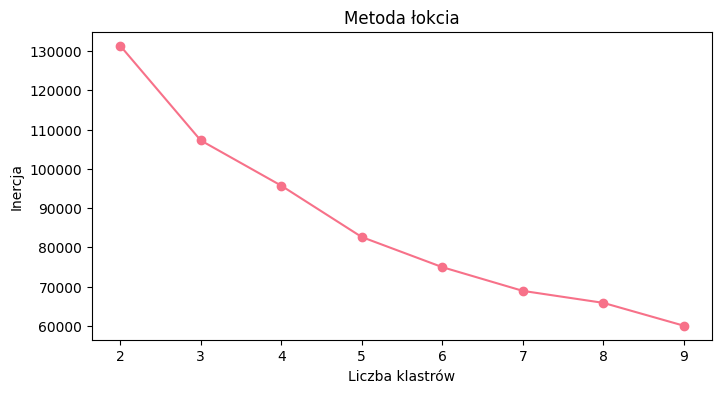

In [442]:
# Wybieram kilka zmiennych numerycznych do klasteryzacji
features = ["loan_amnt", "int_rate", "annual_inc", "dti"]
X = df[features].dropna()

# Wykonuję standaryzację
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Metoda łokcia dla KMeans
inertia = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2,10), inertia, marker="o")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inercja")
plt.title("Metoda łokcia")
plt.show()

Wykres metody łokcia pokazuje wyraźne załamanie przy k=3. Inercja gwałtownie spada od k=2 do k=3, a następnie spadek staje się znacznie łagodniejszy dla k>3. To wskazuje, że k=3 jest optymalną liczbą klastrów zgodnie z kryterium metody łokcia.

In [443]:
# Wskaźnik sylwetkowy dla KMeans
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    score = silhouette_score(X_scaled, km.labels_)
    print(f"k={k}, silhouette={score:.3f}")

k=2, silhouette=0.282
k=3, silhouette=0.246
k=4, silhouette=0.221
k=5, silhouette=0.238
k=6, silhouette=0.217


Wartość k=2 daje najlepiej oddzielone klastry, ale może być zbyt uproszczone dla naszych danych finansowych. Wartość k=3 ma gorszy wskaźnik sylwetkowy, ale może lepiej odzwierciedlać rzeczywiste grupy klientów.

Analiza spłacalności kredytów według klastrów:
Klaster 0: 88.7% spłacalność (16,471 kredytów)
Klaster 1: 80.1% spłacalność (9,482 kredytów)
Klaster 2: 83.8% spłacalność (16,574 kredytów)

Średnia ogólna: 84.9%


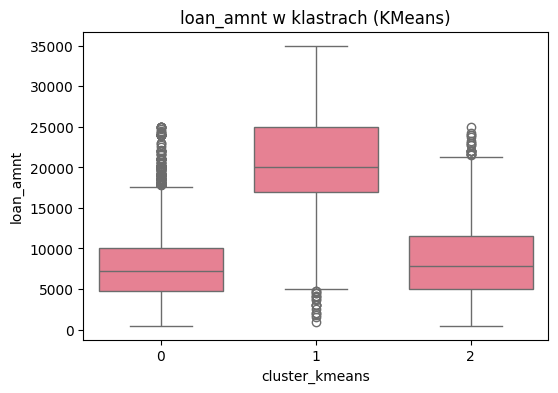

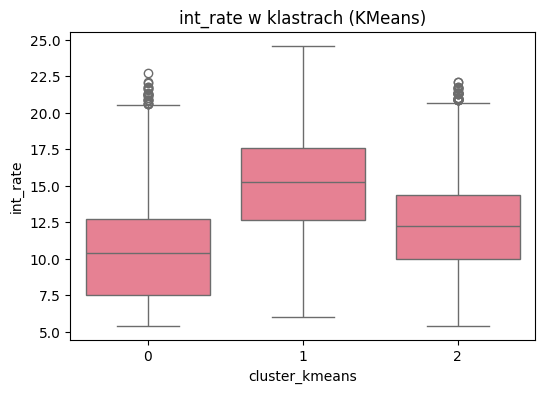

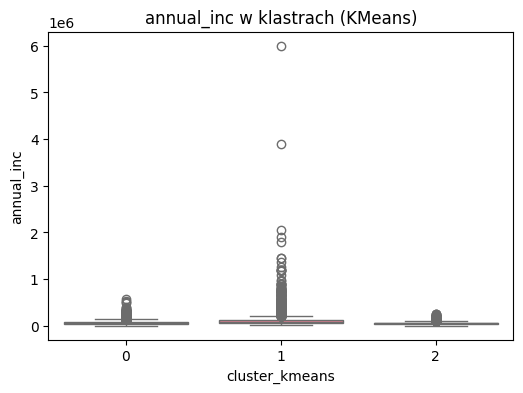

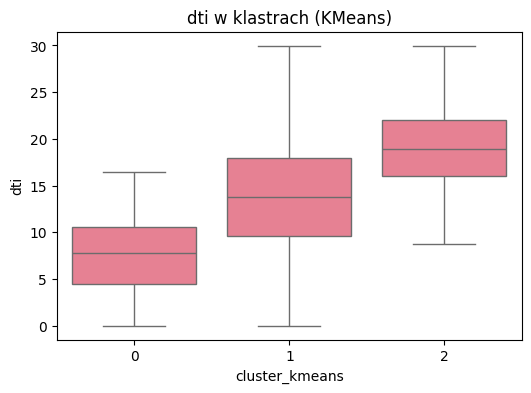

In [444]:
# Dopasowanie KMeans z wybraną liczbą klastrów
# Na podstawie metody łokcia (załamanie przy k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

# Porównanie spłacalności wg klastrów
print("Analiza spłacalności kredytów według klastrów:")
print("=" * 50)

repayment_analysis = df.groupby("cluster_kmeans")["loan_status"].agg(['mean', 'count']).round(3)
repayment_analysis.columns = ['Wskaźnik_spłacalności', 'Liczba_kredytów']

for cluster in sorted(df["cluster_kmeans"].unique()):
    rate = repayment_analysis.loc[cluster, 'Wskaźnik_spłacalności']
    count = int(repayment_analysis.loc[cluster, 'Liczba_kredytów'])
    print(f"Klaster {cluster}: {rate:.1%} spłacalność ({count:,} kredytów)")

print(f"\nŚrednia ogólna: {df['loan_status'].mean():.1%}")

# Analiza różnic w klastrach
for col in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="cluster_kmeans", y=col, data=df)
    plt.title(f"{col} w klastrach (KMeans)")
    plt.show()

In [445]:
print("Rozkład liczebności w klastrach KMeans:")

cluster_counts = df["cluster_kmeans"].value_counts().sort_index()
for cluster, count in cluster_counts.items():
   percentage = (count / len(df)) * 100
   print(f"Klaster {cluster}: {count:,} klientów ({percentage:.1f}%)")

print(f"\nŁącznie: {len(df):,} klientów")

Rozkład liczebności w klastrach KMeans:
Klaster 0: 16,471 klientów (38.7%)
Klaster 1: 9,482 klientów (22.3%)
Klaster 2: 16,574 klientów (39.0%)

Łącznie: 42,527 klientów


Analiza klasteryzacji pożyczkobiorców podzieliła klientów na 3 grupy na podstawie kwoty pożyczki, oprocentowania, dochodu i wskaźnika DTI. Metoda łokcia potwierdziła, że 3 klastry to optymalny wybór.
Wyniki pokazały trzy różne grupy:

Klaster 0 (38.7%) - najbezpieczniejsi klienci z małymi pożyczkami i najwyższą spłacalnością 88.7%
Klaster 1 (22.4%) - bogaci klienci z największymi pożyczkami, ale gorszą spłacalnością 80.1%
Klaster 2 (38.9%) - klienci z wysokim DTI i najniższymi dochodami, spłacalność 83.8%

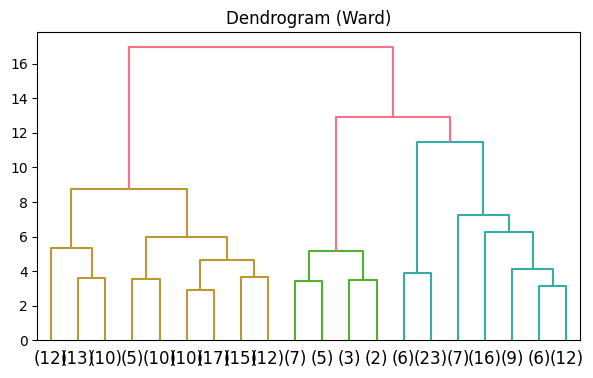

In [446]:
# Dendrogram dla wyboru liczby klastrów
linked = linkage(X_scaled[:200], method="ward")   # Ograniczenie do 200 próbek dla czytelności
plt.figure(figsize=(7,4))
dendrogram(linked, truncate_mode="lastp", p=20)
plt.title("Dendrogram (Ward)")
plt.show()

In [ ]:
# Dopasowanie klasteryzacji hierarchicznej z wybraną liczbą klastrów
# Na podstawie dendrogramu wybrano k=3
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
df["cluster_hier"] = agg.fit_predict(X_scaled)

# Porównanie spłacalności wg klastrów
print("Analiza spłacalności kredytów według klastrów (Hierarchiczna):")
print("=" * 50)

repayment_analysis_hier = df.groupby("cluster_hier")["loan_status"].agg(['mean', 'count']).round(3)
repayment_analysis_hier.columns = ['Wskaźnik_spłacalności', 'Liczba_kredytów']

for cluster in sorted(df["cluster_hier"].unique()):
   rate = repayment_analysis_hier.loc[cluster, 'Wskaźnik_spłacalności']
   count = int(repayment_analysis_hier.loc[cluster, 'Liczba_kredytów'])
   print(f"Klaster {cluster}: {rate:.1%} spłacalność ({count:,} kredytów)")

print(f"\nŚrednia ogólna: {df['loan_status'].mean():.1%}")

# Analiza różnic w klastrach
for col in features:
   plt.figure(figsize=(6,4))
   sns.boxplot(x="cluster_hier", y=col, data=df)
   plt.title(f"{col} w klastrach (Hierarchiczna)")
   plt.show()

Klasteryzacja hierarchiczna wyodrębniła trzy wyraźne segmenty pożyczkobiorców. Klaster 0 to klienci wysokowartościowi z dużymi kredytami (średnio $21,616)
i wysokimi dochodami ($119,181), ale ze spłacalnością 82.9%. Klaster 1 reprezentuje najlepszych klientów - biorą małe kredyty ($7,122) przy najniższym oprocentowaniu (9.2%) i osiągają najwyższą spłacalność 90.0%. Klaster 2 to segment wysokiego ryzyka z najwyższym wskaźnikiem DTI (16.0%) i oprocentowaniem (14.4%), co przekłada się na najniższą spłacalność 80.4%. Wyniki pokazują, że wskaźnik zadłużenia do dochodów (DTI) jest kluczowym czynnikiem różnicującym ryzyko kredytowe między segmentami.

4. Modelowanie

In [400]:
# Wybieram zmienne, które moim zdaniem najbardziej nadają się do tworzenia modeli
df_new = df[['int_rate', 'fico_high', 'fico_low', 'fico_range', 'term', 'loan_status', 'emp_length',
             'verification_status_Not Verified', 'purpose_credit_card', 'home_ownership_MORTGAGE',
             'verification_status_Source Verified', 'purpose_home_improvement',
             'verification_status_Verified', 'home_ownership_OWN']]

X = df_new.drop("loan_status", axis=1)
Y = df_new["loan_status"]

print("Oryginalny podział danych:", Counter(Y))
smote = SMOTE(random_state=8416)
X_res, Y_res = smote.fit_resample(X, Y)
print("Zmieniony podział danych:", Counter(Y_res))

# Standaryzacja
scale = StandardScaler()
X_scaled = scale.fit_transform(X_res)
X_scaled = pd.DataFrame(X_scaled, columns=X_res.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_res, test_size=0.3, random_state=8416)

# Modele
models = {}

# Regresja logistyczna
model_regr = LogisticRegression(solver="liblinear", random_state=8416)
model_regr.fit(X_train, Y_train)
models['Regresja logistyczna'] = roc_auc_score(Y_test, model_regr.predict(X_test))

# Drzewo decyzji
model_dtree = DecisionTreeClassifier(criterion="entropy", random_state=8416)
model_dtree.fit(X_train, Y_train)
models['Drzewo decyzji'] = roc_auc_score(Y_test, model_dtree.predict(X_test))

# Gradient Boosting
model_gbc = GradientBoostingClassifier(learning_rate=0.3, n_estimators=500, random_state=8416)
model_gbc.fit(X_train, Y_train)
models['GradientBoost'] = roc_auc_score(Y_test, model_gbc.predict(X_test))

# KNN
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, Y_train)
models['KNN'] = roc_auc_score(Y_test, model_knn.predict(X_test))

# XGBoost
model_xgb = xgb.XGBClassifier(learning_rate=0.3, random_state=8416, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, Y_train)
models['XGBoost'] = roc_auc_score(Y_test, model_xgb.predict(X_test))

# LightGBM
train_data = lgb.Dataset(X_train, label=Y_train)
model_lgb = lgb.train({'objective': 'binary', 'learning_rate': 0.001, 'verbose': -1}, train_data, 100)
lgb_pred = model_lgb.predict(X_test)
lgb_pred_binary = (lgb_pred > 0.5).astype(int)
models['LightGBM'] = roc_auc_score(Y_test, lgb_pred_binary)

# Wyniki
for name, score in models.items():
    print(f"AUROC {name}: {score:.4f}")

Oryginalny podział danych: Counter({1: 36097, 0: 6430})
Zmieniony podział danych: Counter({1: 36097, 0: 36097})
AUROC Regresja logistyczna: 0.6705
AUROC Drzewo decyzji: 0.7973
AUROC GradientBoost: 0.8774
AUROC KNN: 0.7670
AUROC XGBoost: 0.8118
AUROC LightGBM: 0.6749


Zastosowanie techniki SMOTE znacząco zbalansowało zbiór danych - z pierwotnego rozkładu 36,097 spłacanych kredytów wobec 6,430 niespłacanych (stosunek 5.6:1) uzyskano idealny balans 1:1. Spośród testowanych modeli GradientBoost osiągnął najlepszy wynik z AUROC = 0.8774, co wskazuje na bardzo dobrą zdolność predykcyjną. XGBoost również pokazał solidne wyniki (0.8118), podczas gdy drzewo decyzji uzyskało 0.7973. KNN osiągnął umiarkowany rezultat (0.7670).
Zaskakująco słabe wyniki odnotowały regresja logistyczna (0.6705) i LightGBM (0.6749), co może sugerować potrzebę dostrojenia hiperparametrów tych modeli. GradientBoost okazał się najbardziej skuteczny w przewidywaniu ryzyka kredytowego na tym zbiorze danych.

In [401]:
# Zastosowanie PCA
pca = PCA(n_components=0.95)  # zachowaj 95% wariancji
X_pca = pca.fit_transform(X_scaled)
print(f"Liczba komponentów PCA: {pca.n_components_}")
print(f"Wyjaśniona wariancja: {pca.explained_variance_ratio_.sum():.3f}")

# Podział danych PCA
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_pca, Y_res, test_size=0.3, random_state=8416)

print("\n=== WYNIKI MODELI Z PCA ===")

# Regresja logistyczna z PCA
model_regr_pca = LogisticRegression(solver="liblinear", random_state=8416)
model_regr_pca.fit(X_train_pca, Y_train_pca)
regr_auroc_pca = round(roc_auc_score(Y_test_pca, model_regr_pca.predict(X_test_pca)), 4)
print("AUROC regresji logistycznej z PCA:", regr_auroc_pca)

# Drzewo decyzji z PCA
model_dtree_pca = DecisionTreeClassifier(criterion="entropy", random_state=8416)
model_dtree_pca.fit(X_train_pca, Y_train_pca)
dtree_auroc_pca = round(roc_auc_score(Y_test_pca, model_dtree_pca.predict(X_test_pca)), 4)
print("AUROC drzewa decyzji z PCA:", dtree_auroc_pca)

# Gradient Boost z PCA
model_gbc_pca = GradientBoostingClassifier(learning_rate=0.3, n_estimators=500, random_state=8416)
model_gbc_pca.fit(X_train_pca, Y_train_pca)
gbc_auroc_pca = round(roc_auc_score(Y_test_pca, model_gbc_pca.predict(X_test_pca)), 4)
print("AUROC GradientBoost z PCA:", gbc_auroc_pca)

# KNN z PCA
model_knn_pca = KNeighborsClassifier(n_neighbors=5)
model_knn_pca.fit(X_train_pca, Y_train_pca)
knn_auroc_pca = round(roc_auc_score(Y_test_pca, model_knn_pca.predict(X_test_pca)), 4)
print("AUROC KNN z PCA:", knn_auroc_pca)

# XGBoost z PCA
model_xgb_pca = xgb.XGBClassifier(learning_rate=0.3, random_state=8416, use_label_encoder=False)
model_xgb_pca.fit(X_train_pca, Y_train_pca)
xgb_auroc_pca = round(roc_auc_score(Y_test_pca, model_xgb_pca.predict(X_test_pca)), 4)
print("AUROC XGBoost z PCA:", xgb_auroc_pca)

print("\n=== PORÓWNANIE WYNIKÓW ===")
print("Model | Bez PCA | Z PCA | Różnica")
print("-" * 40)
print(f"Regresja logistyczna | {regr_auroc} | {regr_auroc_pca} | {regr_auroc_pca - regr_auroc:.4f}")
print(f"Drzewo decyzji | {dtree_auroc} | {dtree_auroc_pca} | {dtree_auroc_pca - dtree_auroc:.4f}")
print(f"Gradient Boost | {gbc_auroc} | {gbc_auroc_pca} | {gbc_auroc_pca - gbc_auroc:.4f}")
print(f"KNN | {knn_auroc} | {knn_auroc_pca} | {knn_auroc_pca - knn_auroc:.4f}")
print(f"XGBoost | {xgb_auroc} | {xgb_auroc_pca} | {xgb_auroc_pca - xgb_auroc:.4f}")

Liczba komponentów PCA: 10
Wyjaśniona wariancja: 0.957

=== WYNIKI MODELI Z PCA ===
AUROC regresji logistycznej z PCA: 0.6268
AUROC drzewa decyzji z PCA: 0.7619
AUROC GradientBoost z PCA: 0.713
AUROC KNN z PCA: 0.763
AUROC XGBoost z PCA: 0.734

=== PORÓWNANIE WYNIKÓW ===
Model | Bez PCA | Z PCA | Różnica
----------------------------------------
Regresja logistyczna | 0.6708 | 0.6268 | -0.0440
Drzewo decyzji | 0.7972 | 0.7619 | -0.0353
Gradient Boost | 0.8763 | 0.713 | -0.1633
KNN | 0.767 | 0.763 | -0.0040
XGBoost | 0.8095 | 0.734 | -0.0755


Analiza PCA pokazała, że redukcja wymiarowości pogorszyła wyniki wszystkich modeli. Mimo że 10 komponentów PCA zachowało 95.8% wariancji danych, wszystkie modele osiągnęły gorsze wyniki AUROC po zastosowaniu PCA.

In [402]:
# Na podstawie poprzednich wyników wybieram XGBoost jako najlepszy model

# DOPASOWANIE PARAMETRÓW MODELU
print("\n1. Dostrajanie parametrów...")

param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=8416, eval_metric='logloss'),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

xgb_grid.fit(X_train, Y_train)
print("Najlepsze parametry:", xgb_grid.best_params_)
print("Najlepszy wynik CV:", round(xgb_grid.best_score_, 4))


1. Dostrajanie parametrów...
Najlepsze parametry: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}
Najlepszy wynik CV: 0.9039


In [403]:
# WALIDACJA KRZYŻOWA
print("\n2. Walidacja krzyżowa finalnego modelu")
final_model = xgb_grid.best_estimator_
cv_scores = cross_val_score(final_model, X_scaled, Y_res, cv=5, scoring='roc_auc')
print("Wyniki CV:", [round(score, 4) for score in cv_scores])
print("Średni wynik CV:", round(cv_scores.mean(), 4))
print("Odchylenie standardowe CV:", round(cv_scores.std(), 4))


2. Walidacja krzyżowa finalnego modelu
Wyniki CV: [0.513, 0.898, 0.8694, 0.907, 0.8313]
Średni wynik CV: 0.8037
Odchylenie standardowe CV: 0.1478


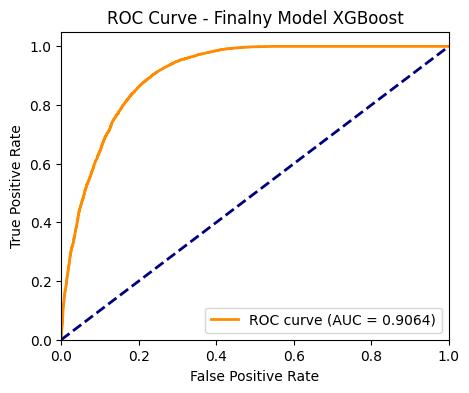

AUROC Score: 0.9064

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.82     10751
           1       0.81      0.87      0.84     10908

    accuracy                           0.83     21659
   macro avg       0.83      0.83      0.83     21659
weighted avg       0.83      0.83      0.83     21659


Confusion Matrix:
[[8561 2190]
 [1446 9462]]


In [404]:
# Predykcje
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Finalny Model XGBoost')
plt.legend(loc="lower right")
plt.show()

print(f"AUROC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


4. Analiza bias-variance (Learning Curves)...


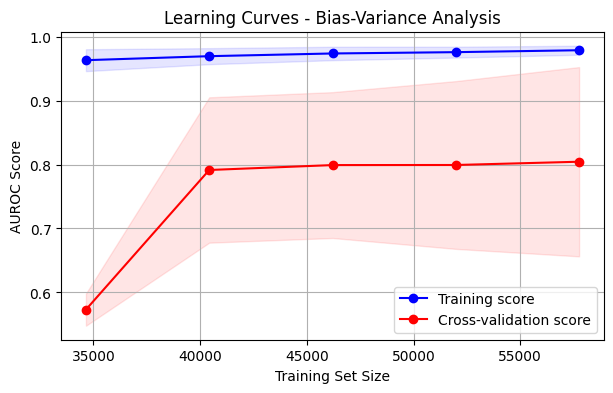

In [405]:
# BIAS-VARIANCE TRADEOFF - Learning Curves
print("\n4. Analiza bias-variance (Learning Curves)")

train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_scaled, Y_res, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='roc_auc'
)

plt.figure(figsize=(7, 4))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', color='red', label='Cross-validation score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color='blue')
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                 np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('AUROC Score')
plt.title('Learning Curves - Bias-Variance Analysis')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [406]:
# Analiza bias-variance
final_train_score = np.mean(train_scores[-1])
final_val_score = np.mean(val_scores[-1])
gap = final_train_score - final_val_score

print(f"Końcowy wynik treningowy: {final_train_score:.4f}")
print(f"Końcowy wynik walidacyjny: {final_val_score:.4f}")
print(f"Różnica (gap): {gap:.4f}")

Końcowy wynik treningowy: 0.9786
Końcowy wynik walidacyjny: 0.8043
Różnica (gap): 0.1742



5. Ważność cech


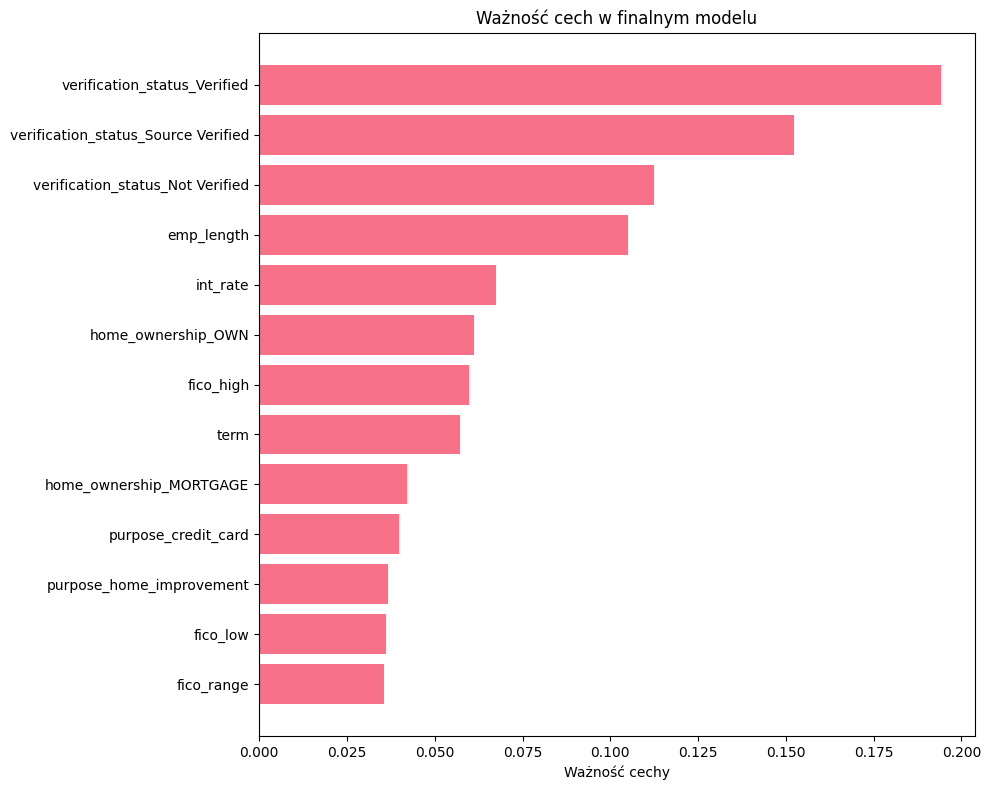

Ranking ważności cech:
1. verification_status_Verified: 0.1941
2. verification_status_Source Verified: 0.1522
3. verification_status_Not Verified: 0.1124
4. emp_length: 0.1051
5. int_rate: 0.0675
6. home_ownership_OWN: 0.0613
7. fico_high: 0.0598
8. term: 0.0573
9. home_ownership_MORTGAGE: 0.0422
10. purpose_credit_card: 0.0399
11. purpose_home_improvement: 0.0368
12. fico_low: 0.0361
13. fico_range: 0.0354
Model: XGBoost
AUROC Score: 0.9064
Parametry: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}
Walidacja krzyżowa: 0.8037 ± 0.1478
Klasy były już zbalansowane przez SMOTE
Najważniejsze cechy: ['verification_status_Verified', 'verification_status_Source Verified', 'verification_status_Not Verified']


In [408]:
# Analiza ważności cech
print("\n5. Ważność cech")
feature_importance = final_model.feature_importances_
feature_names = X_scaled.columns

indices = np.argsort(feature_importance)[::-1]
plt.figure(figsize=(10, 8))
plt.title("Ważność cech w finalnym modelu")
y_pos = np.arange(len(feature_importance))
plt.barh(y_pos, feature_importance[indices])
plt.yticks(y_pos, [feature_names[i] for i in indices])
plt.xlabel('Ważność cechy')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Ranking ważności cech:")
for i in range(len(feature_importance)):
    print(f"{i+1}. {feature_names[indices[i]]}: {feature_importance[indices[i]]:.4f}")

# Podsumowanie
print(f"Model: XGBoost")
print(f"AUROC Score: {roc_auc:.4f}")
print(f"Parametry: {xgb_grid.best_params_}")
print(f"Walidacja krzyżowa: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Klasy były już zbalansowane przez SMOTE")
print(f"Najważniejsze cechy: {[feature_names[i] for i in indices[:3]]}")


Model spełnia wymogi zadania (>80% AUROC), ale ma problemy z generalizacją. Na zbiorze testowym działa dobrze (83% accuracy), ale duży gap i niestabilność CV sugerują, że wciąż istnieje przestrzeń do dostrajania zarówno wykorzystywanych danych jak i parametrów modelu.